Qiskit Runtime concept: https://www.youtube.com/watch?v=gSK3XRuLKB4

Tutorials: 
* https://github.com/Qiskit/qiskit-ibm-runtime
* https://docs.quantum.ibm.com/run/primitives
* https://github.com/Qiskit-Partners/qiskit-runtime/blob/main/tutorials/sample_vqe_program/qiskit_runtime_vqe_program.ipynb

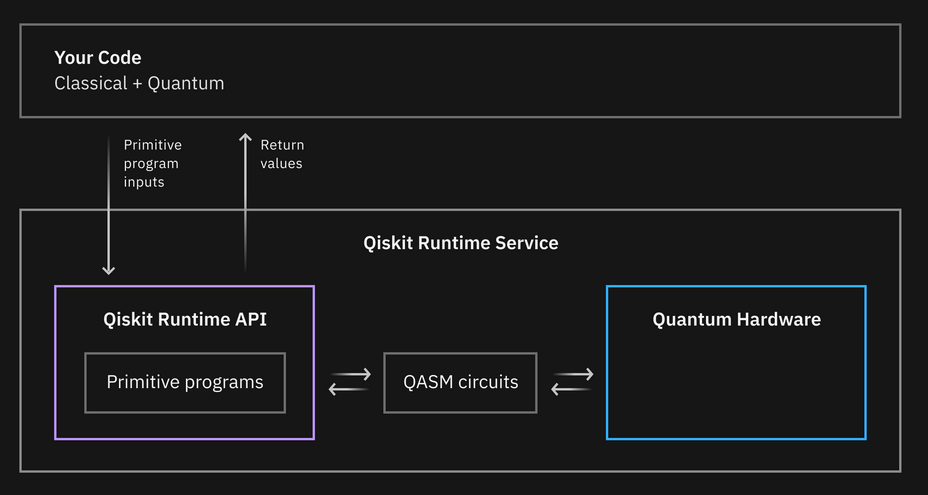

`!pip install qiskit-ibm-runtime`

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler
from qiskit import QuantumCircuit

In [1]:
# Save an IBM Cloud account:
#QiskitRuntimeService.save_account(channel="ibm_cloud", token="MY_IBM_CLOUD_API_KEY", instance="MY_IBM_CLOUD_CRN")

# Save an IBM Quantum account:
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")

In [2]:
#service_cloud = QiskitRuntimeService()
service_cloud = QiskitRuntimeService(channel="ibm_cloud")

In [3]:
service_cloud.pprint_programs(limit=10)

qasm3-runner:
  Name: qasm3-runner
  Description: A runtime program that takes one or more circuits, converts them to OpenQASM3, compiles and executes them. This program can also take and execute one or more OpenQASM3 strings. Note that this program can only run on a backend that supports OpenQASM3.
circuit-runner:
  Name: circuit-runner
  Description: A runtime program that takes one or more circuits, compiles and executes them.
sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
estimator:
  Name: estimator
  Description: Calculates expectation values of quantum operators.


In [4]:
print(service_cloud.program("sampler"))

sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
  Creation date: 2021-10-26T14:41:57Z
  Update date: 2023-08-19T14:44:05.186546Z
  Max execution time: 10000
  Backend requirements:
    none
  Input parameters:
    Properties:
        - circuit_ids:
            Description: A list of unique IDs of QuantumCircuits.
            Type: array
            Required: False
        - circuit_indices:
            Description: Indices of the circuits to evaluate.
            Type: array
            Required: True
        - circuits:
            Description: A single or list or dictionary of QuantumCircuits.
            Type: ['array', 'object']
            Required: True
        - parameter_values:
            Description: A list of concrete parameters to be bound for each circuit. If specified, it must have the same length as circuit_indices.
            Type: array
            Required: False
        - parameters:
            Description: Param

In [5]:
service_cloud.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>]

# Sampler

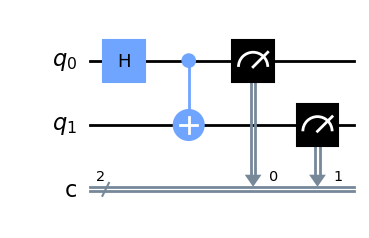

In [6]:
bell = QuantumCircuit(2,2)
bell.h(0)
bell.cx(0, 1)
bell.measure(0,0)
bell.measure(1,1)

bell.draw('mpl')

In [7]:
options = Options(optimization_level=1)
options.execution.shots = 1024

with Session(service=service_cloud, backend="ibmq_qasm_simulator") as session:
    sampler = Sampler(session=session, options=options)
    job = sampler.run(circuits=bell)
    result = job.result()
    print(f"Job ID is {job.job_id()}")
    print(f"Job result is {result}")

    #  More executions (of Sampler and/or Estimator) can go here to leverage the session


Job ID is clu1qse9qgrpo828nkfg
Job result is SamplerResult(quasi_dists=[{3: 0.509765625, 0: 0.490234375}], metadata=[{'shots': 1024, 'circuit_metadata': {}}])


In [8]:
print(f" > Quasi probability distribution: {result.quasi_dists[0]}")
print(f" > Metadata: {result.metadata[0]}")

 > Quasi probability distribution: {3: 0.509765625, 0: 0.490234375}
 > Metadata: {'shots': 1024, 'circuit_metadata': {}}


In [10]:
program_inputs = {
    "circuits": bell,
    "circuit_indices": [0],
}

options = {"backend": "ibmq_qasm_simulator"}
job = service_cloud.run(program_id="sampler",
                  options=options,
                  inputs=program_inputs
                 )
print(job.job_id())

result = job.result()
print(result)

clu1rle46skq4air60mg
SamplerResult(quasi_dists=[{0: 0.4677734375, 3: 0.5322265625}], metadata=[{'shots': 1024, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.018080543726682663}])


In [11]:
result_dict = result.quasi_dists[0].binary_probabilities()

print(result_dict)

{'00': 0.4677734375, '11': 0.5322265625}


## Execise 7.1
* Use Qiskit Runtime Sampler program hosted on IBM Cloud to run Grover algorithm on 4 qubits.
* Use Oracle of your choice.
* Run on simulator (through IBM Cloud)

# Estimator

We'll start with whiteboard theory ;)

Then, I'd like you to use Qiskit documentation (https://docs.quantum.ibm.com/) to learn how to use Estimator ;)

## Execise 7.2
* Use Qiskit Runtime Estimator to calculate expectation value of ZZ in state |01>

## Execise 7.3
Find value of the parameter in the following circuit:
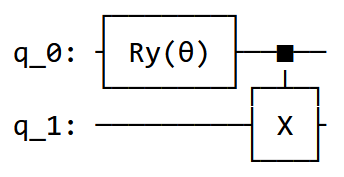
corresponding to minimal expectation value of the operator - 0.3 * ZZ - 0.5 * XX - 0.4 * YY

# Custom Qiskit Runtime programs (not working currently)

In [12]:
"""A sample runtime program that submits random circuits for user-specified iterations."""

import random

from qiskit import transpile
from qiskit.circuit.random import random_circuit


def prepare_circuits(backend):
    circuit = random_circuit(
        num_qubits=5, depth=4, measure=True, seed=random.randint(0, 1000)
    )
    return transpile(circuit, backend)


def main(backend, user_messenger, **kwargs):
    iterations = kwargs.pop("iterations", 5)
    for it in range(iterations):
        qc = prepare_circuits(backend)
        result = backend.run(qc).result()
        user_messenger.publish({"iteration": it, "counts": result.get_counts()})

    return "Hello, World!"

In [13]:
import json
import hello_world_example
from qiskit import Aer
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder
from qiskit.providers.ibmq.runtime import UserMessenger
msg = UserMessenger()

inputs = {"iterations": 3}

backend = Aer.get_backend("qasm_simulator")
user_messenger = UserMessenger()
serialized_inputs = json.dumps(inputs, cls=RuntimeEncoder)
deserialized_inputs = json.loads(serialized_inputs, cls=RuntimeDecoder)

hello_world_example.main(backend, user_messenger, **deserialized_inputs)

{"iteration": 0, "counts": {"10111": 137, "00011": 90, "11011": 149, "10000": 18, "11100": 18, "10011": 143, "00101": 13, "00111": 88, "11000": 31, "00000": 17, "01111": 48, "01000": 21, "01011": 66, "11111": 90, "01001": 7, "00001": 19, "01100": 13, "10100": 19, "01101": 13, "11101": 2, "11110": 4, "10010": 3, "00100": 10, "10101": 1, "11001": 1, "10110": 2, "11010": 1}}
{"iteration": 1, "counts": {"00100": 46, "01000": 6, "00000": 440, "11000": 6, "10000": 480, "10100": 41, "10110": 3, "01100": 1, "00010": 1}}
{"iteration": 2, "counts": {"00001": 80, "10000": 420, "00000": 55, "10001": 469}}


'Hello, World!'

In [14]:
import os
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")

hello_world_example_data = "hello_world_example.py"
hello_world_example_json = "hello_world_example.json"

program_id = service.upload_program(data=hello_world_example_data, metadata=hello_world_example_json)
print(program_id)

IBMNotAuthorizedError: 'You are not authorized to upload programs.'

In [ ]:
# service.update_program(program_id=program_id, description="A new description.")
# service.delete_program(program_id)

In [15]:
service.pprint_programs(limit=10)

circuit-runner:
  Name: circuit-runner
  Description: A runtime program that takes one or more circuits, compiles and executes them.
estimator:
  Name: estimator
  Description: Calculates expectation values of quantum operators.
sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
qasm3-runner:
  Name: qasm3-runner
  Description: A runtime program that takes one or more circuits, converts them to OpenQASM3, compiles and executes them. This program can also take and execute one or more OpenQASM3 strings. Note that this program can only run on a backend that supports OpenQASM3.


In [16]:
service.pprint_programs(limit=10, detailed=True)

circuit-runner:
  Name: circuit-runner
  Description: A runtime program that takes one or more circuits, compiles and executes them.
  Creation date: 2021-07-02T13:46:10.000Z
  Update date: 2023-08-19T14:44:07.776Z
  Max execution time: 14400
  Backend requirements:
    none
  Input parameters:
    Properties:
        - shots:
            Type: integer
            Default: 4000
            Description: Number of repetitions of each circuit, for sampling. Default: 1024.
            Required: False
        - header:
            Type: object
            Description: User input that will be attached to the job and will be copied to the corresponding result header.
            Required: False
        - memory:
            Type: boolean
            Default: False
            Description: Whether to return per-shot measurement bitstrings.
            Required: False
        - circuits:
            Type: ['object', 'array']
            Description: A circuit or a list of QuantumCircuits or a l

In [17]:
print(service.program(program_id))

NameError: name 'program_id' is not defined

In [11]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_oslo')>]

In [13]:
options = {'backend_name': 'ibmq_qasm_simulator'}
program_inputs = {'iterations': 1}

job = service.run(program_id="hello-world-example-80y3KNMRMY",
                  options=options,
                  inputs=program_inputs
                 )
print(f"job id: {job.job_id}")
result = job.result()
print(result)

C:\Users\P39686~1\AppData\Local\Temp/ipykernel_23072/713572788.py:4: DeprecationWarning: Note that the 'job_id' and 'backend' attributes of a runtime job have been deprecated as of qiskit-ibm-runtime 0.7 and will be removed no sooner than 3 months after the release date. Please use the job_id() and backend() methods instead.
  job = service.run(program_id="hello-world-example-80y3KNMRMY",


job id: cegde5bu4l118bju8av0
Hello, World!
